<a href="https://colab.research.google.com/github/lu-jeremy/Actor-Critic-Methods/blob/main/AC_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning Notebook for Actor-Critic Methods

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gym

import os

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
#@title Helper Methods

!pip install tensorflow_docs

# Gym Box2D + Mujoco Dependencies; this line is key
!apt install swig

!pip install Cmake
!pip install box2d pygame
!pip install box2d-py
!pip install gym[box2d]

!pip install gym[mujoco]
!pip install pyglet==1.5.11
!pip install mujoco-py==0.5.7

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!pip install imageio==2.4.1

!mkdir tmp
!mkdir tmp/dppg
!mkdir tmp/td3

def plot_learning_curve(x, scores, prog_file):
  running_avg = np.zeros(len(scores))
  for i in range(len(running_avg)):
    running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])

  plt.plot(x, running_avg)
  plt.title('Avg of scores')
  plt.savefig(prog_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 4.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,031 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 129824 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selec

# Vanilla Actor-Critic Methods

In [ ]:
class ActorCritic(tf.keras.Model):
  def __init__(self, n_actions, fc1_dims=1024, fc2_dims=512,
               name='ActorCritic', chkpt_dir='tmp/actor_critic'):
    super(ActorCritic, self).__init__()

    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.model_name = name
    self.chkpt_dir = chkpt_dir
    self.chkpt_file = os.path.join(self.chkpt_dir, name + '_ac')

    self.fc1 = Dense(self.fc1_dims, activation='relu')
    self.fc2 = Dense(self.fc2_dims, activation='relu')
    self.v = Dense(1)
    self.pi = Dense(n_actions, activation='softmax')

  def call(self, state):
    x = self.fc1(state)
    x = self.fc2(x)

    v = self.v(x)
    pi = self.pi(x)

    return v, pi

In [ ]:
class Agent:
  # usually gamma = 0.99 is good enough
  def __init__(self, alpha=0.0003, gamma=0.99, n_actions=2):
    self.gamma = gamma
    self.n_actions = n_actions
    self.action = None

    self.action_space = [i for i in range(self.n_actions)]

    self.actor_critic = ActorCritic(n_actions=self.n_actions)
    self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))

  def choose_action(self, observation):
    state = tf.convert_to_tensor([observation])
    v, policy_probs = self.actor_critic(state)

    action_probs = tfp.distributions.Categorical(probs=policy_probs)
    action = action_probs.sample()
    log_prob = action_probs.log_prob(action)
    self.action = action

    return action.numpy()[0]

  def save_model(self):
    print('saving...')
    self.actor_critic.save_weights(self.actor_critic.chkpt_file)

  def load_model(self):
    print('loading...')
    self.actor_critic.load_weights(self.actor_critic.chkpt_file)

  def compute_loss(self, v_state, reward, v_state_, log_prob, done):
    advantage = reward + self.gamma * v_state_ * (1-int(done)) - v_state

    # policy gradient wrt higher advantage leads to a higher prob for taking respective action
    actor_loss = -log_prob * advantage
    critic_loss = advantage**2

    total_loss = actor_loss + critic_loss

    return total_loss

  # @tf.function
  def train_step(self, state, reward, state_, done):
    '''
    @tf.function decorator leads to significantly worse performance, despite its seemingly computational advantage
    Graph mode cannot convert the log_prob() function properly
    '''
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
    reward  = tf.convert_to_tensor(reward, dtype=tf.float32)

    with tf.GradientTape() as tape:
      # total_loss = self.compute_loss(state, reward, state_, done)
      v_state, pi_probs = self.actor_critic(state, training=True)
      v_state_, _ = self.actor_critic(state_, training=True)

      v_state = tf.squeeze(v_state)
      v_state_ = tf.squeeze(v_state_)

      action_probs = tfp.distributions.Categorical(probs=pi_probs)

      log_prob = action_probs.log_prob(self.action)

      total_loss = self.compute_loss(v_state, reward, v_state_, log_prob, done)

    gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
    self.actor_critic.optimizer.apply_gradients(zip(gradient, self.actor_critic.trainable_variables))


  # print(tf.autograph.to_code(train_step.python_function))

In [ ]:
def train_sim():
  env = gym.make('CartPole-v0')
  agent = Agent(alpha=1e-5, n_actions=env.action_space.n)
  n_games = 1800

  progress_dir = 'prog.png'

  best_score = env.reward_range[0]
  # print(best_score)

  score_history = []

  load_chkpt = False
  if load_chkpt:
    agent.load_model()

  for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
      action = agent.choose_action(observation)
      # print('ACTION', action)
      observation_, reward, done, info = env.step(action)
      score += reward
      if not load_chkpt:
        agent.train_step(observation, reward, observation_, done)
      observation = observation_

    score_history.append(score)
    # mean score of most recent 100 games
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
      best_score = avg_score
      if not load_chkpt:
        agent.save_model()

    print('episode', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

  x = [i+1 for i in range(n_games)]
  plot_learning_curve(x, score_history, progress_dir)

train_sim()

saving...
episode 0 score 25.0 avg_score 25.0
episode 1 score 18.0 avg_score 21.5
episode 2 score 15.0 avg_score 19.3
episode 3 score 24.0 avg_score 20.5
episode 4 score 23.0 avg_score 21.0
episode 5 score 15.0 avg_score 20.0
episode 6 score 11.0 avg_score 18.7
episode 7 score 17.0 avg_score 18.5
episode 8 score 70.0 avg_score 24.2
episode 9 score 10.0 avg_score 22.8
episode 10 score 29.0 avg_score 23.4
episode 11 score 32.0 avg_score 24.1
episode 12 score 20.0 avg_score 23.8
episode 13 score 32.0 avg_score 24.4
episode 14 score 20.0 avg_score 24.1
episode 15 score 18.0 avg_score 23.7
episode 16 score 21.0 avg_score 23.5
episode 17 score 11.0 avg_score 22.8
episode 18 score 13.0 avg_score 22.3
episode 19 score 22.0 avg_score 22.3
episode 20 score 19.0 avg_score 22.1
episode 21 score 17.0 avg_score 21.9
episode 22 score 12.0 avg_score 21.5
episode 23 score 12.0 avg_score 21.1
episode 24 score 15.0 avg_score 20.8
episode 25 score 21.0 avg_score 20.8
episode 26 score 30.0 avg_score 21.2
e

KeyboardInterrupt: ignored

In [ ]:
def render_sim():
  env = gym.make('CartPole-v0', render_mode='rgb_array')
  agent = Agent(alpha=1e-5, n_actions=env.action_space.n)

  state = env.reset()
  screen = env.render()[0]
  images = [Image.fromarray(screen)]

  done = False
  i = 0
  while not done:
    action = agent.choose_action(state)
    state, reward, done, info = env.step(action)

    screen = env.render()[0]
    images.append(Image.fromarray(screen))

    if done:
      break

    i += 1

  return images

images = render_sim()
image_file = 'cartpole-v0.gif'
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


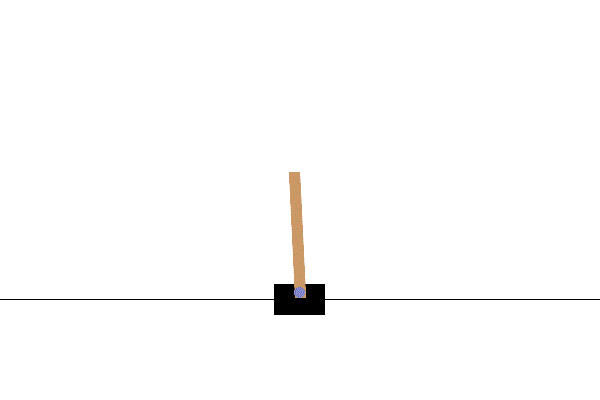

In [ ]:
!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed

embed.embed_file(image_file)

# Deep Deterministic Policy Gradient (DDPG) Methods

In [ ]:
class ReplayBuffer:
  def __init__(self, max_size, input_shape, n_actions):
    self.mem_size = int(max_size)
    self.mem_cntr = 0

    # *input_shape unpacks all tuple elements into argument
    self.state_mem = np.zeros((self.mem_size, *input_shape))
    self.new_state_mem = np.zeros((self.mem_size, *input_shape))
    self.action_mem = np.zeros((self.mem_size, n_actions))
    self.reward_mem = np.zeros(self.mem_size)
    self.terminal_mem = np.zeros(self.mem_size, dtype=bool)

  def store_transition(self, state, action, reward, new_state, terminal_flag):
    '''
    Store episodic memory from buffer
    '''
    # iteratively replace memory tensors
    idx = self.mem_cntr % self.mem_size

    self.state_mem[idx] = state
    self.new_state_mem[idx] = new_state
    self.action_mem[idx] = action
    self.reward_mem[idx] = reward
    self.terminal_mem[idx] = terminal_flag

    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    '''
    Retrieve episodic memory from buffer
    '''
    # choose from only historically recorded memory
    max_mem = min(self.mem_cntr, self.mem_size)
    batch_idx = np.random.choice(max_mem, batch_size, replace=False)

    states = self.state_mem[batch_idx]
    states_ = self.new_state_mem[batch_idx]
    action = self.action_mem[batch_idx]
    reward = self.reward_mem[batch_idx]
    terminal_flag = self.terminal_mem[batch_idx]

    return states, action, reward, states_, terminal_flag

In [ ]:
class Critic(tf.keras.Model):
  def __init__(self, fc1_dims=512, fc2_dims=512, \
               name='critic', chkpt_dir='tmp/ddpg'):
    super(Critic, self).__init__()

    # restricted super class private attribute 'name'
    self.model_name = name

    self.chkpt_dir = os.path.join(chkpt_dir, self.model_name + '_ddpg.h5')

    self.fc1 = Dense(fc1_dims, activation='relu')
    self.fc2 = Dense(fc2_dims, activation='relu')

    # linear activation
    self.q = Dense(1)

  def call(self, state, action):
    x = self.fc1(tf.concat([state, action], axis=1))
    x = self.fc2(x)

    q = self.q(x)

    return q

In [ ]:
class Actor(tf.keras.Model):
  def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, \
               name='actor', chkpt_dir='tmp/ddpg'):
    super(Actor, self).__init__()

    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims

    self.model_name = name
    self.n_actions = n_actions
    self.chkpt_dir = os.path.join(chkpt_dir, self.model_name + '_ddpg.h5')

    self.fc1 = Dense(self.fc1_dims, activation='relu')
    self.fc2 = Dense(self.fc2_dims, activation='relu')
    # policy outputs continuous action state probabilities
    self.mu = Dense(self.n_actions, activation='tanh')

  def call(self, state):
    x = self.fc1(state)
    x = self.fc2(x)
    mu = self.mu(x)
    return mu

In [ ]:
class Agent:
  def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None, \
               gamma=0.99, n_actions=2, max_size=1e6, tau=0.005, \
               batch_size=64, noise=0.1):
    self.gamma = gamma
    self.batch_size = batch_size
    self.noise = noise
    self.tau = tau
    self.n_actions = n_actions

    # nested array indexing
    self.max_act = env.action_space.high[0]
    self.min_act = env.action_space.low[0]

    self.mem = ReplayBuffer(max_size, input_dims, n_actions)

    self.actor = Actor(n_actions=n_actions)
    self.critic = Critic()
    self.target_actor = Actor(n_actions=n_actions, name='target_actor')
    self.target_critic = Critic(name='target_critic')

    act_opt = Adam(learning_rate=alpha)
    crit_opt = Adam(learning_rate=beta)

    self.actor.compile(optimizer=act_opt)
    self.critic.compile(optimizer=crit_opt)
    self.target_actor.compile(optimizer=act_opt)
    self.target_critic.compile(optimizer=crit_opt)

    self.update_network_params(tau=1)

  def update_network_params(self, tau=None):
    if tau is None:
      tau = self.tau

    model_list = {self.actor : self.target_actor, self.critic : self.target_critic}
    for online_model in model_list:
      weights = []
      target_model = model_list[online_model]
      for i, w in enumerate(online_model.weights):
        weights.append(tau * w + (1-tau) * target_model.weights[i])
      target_model.set_weights(weights)

  def save_models(self):
    tf.print('... saving ...')

    self.actor.save_weights(self.actor.chkpt_dir)
    self.critic.save_weights(self.critic.chkpt_dir)
    self.target_actor.save_weights(self.target_actor.chkpt_dir)
    self.target_critic.save_weights(self.target_critic.chkpt_dir)

  def load_models(self):
    tf.print('... loading ...')

    self.actor.load_weights(self.actor.chkpt_dir)
    self.critic.load_weights(self.critic.chkpt_dir)
    self.target_actor.load_weights(self.target_actor.chkpt_dir)
    self.target_critic.load_weights(self.target_critic.chkpt_dir)

  def remember(self, s, a, r, s_, terminal_flag):
    # interface method
    self.mem.store_transition(s, a, r, s_, terminal_flag)

  def choose_action(self, observation, evaluate=False):
    state = tf.convert_to_tensor([observation], dtype=tf.float32)
    actions = self.actor(state)
    # don't add noise when testing
    if not evaluate:
      # add Gaussian noise for exploration-exploit strategy
      actions += tf.random.normal(shape=[self.n_actions], \
                                  mean=0.0, stddev=self.noise)
    # added/subtracted noise may be outside action range
    actions = tf.clip_by_value(actions, self.min_act, self.max_act) * self.max_act

    return actions[0]

  # when running tf.function, set training=True for all model calls, or else exceptions will be thrown
  @tf.function
  def learn(self, s, s_, a, r, terminal_flag):
    '''
    Update Critic network
      - Target actor: s_t+1 -> a_t+1
      - Target critic: s_t+1, a_t+1 -> q(s_t+1, a_t+1)
      - Critic: s_t, a_t -> q(s_t, a_t)
      - Compute mean squared error and update parameters

    Update Actor network
      - Actor: s_t -> predicted a_t
      - Critic: s_t, pred a_t -> q(s_t, pred a_t)
      - Compute expected value of negative q value
      - Perform gradient ascent
    '''
    with tf.GradientTape() as tape:
      a_ = self.target_actor(s_, training=True)
      # estimated payoffs for critic nets
      q_target = tf.squeeze(\
                            self.target_critic(state=s_, action=a_, training=True), 1)
      q = tf.squeeze(\
                     self.critic(state=s, action=a, training=True), 1)

      # initial reward + discounted future payoff
      # terminal_flag: there is no future payoff in terminal state
      target = r + self.gamma * q_target * terminal_flag
      loss = tf.math.reduce_mean(tf.math.square(target - q))

    # update critic net
    grads = tape.gradient(loss, self.critic.trainable_variables)
    self.critic.optimizer.apply_gradients(\
                                          zip(grads, self.critic.trainable_variables))

    with tf.GradientTape() as tape:
      pred_a = self.actor(s, training=True)
      # expected value of critic network output
      actor_loss = -tf.math.reduce_mean(\
                                        self.critic(state=s, action=pred_a, training=True))

    # gradient of Q-value wrt to actor params is implictly expressed in tf graph
    grads = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor.optimizer.apply_gradients(\
                                         zip(grads, self.actor.trainable_variables))

  def train_step(self):
    if self.mem.mem_cntr < self.batch_size:
      return

    # retrieve memory from buffer
    s, a, r, s_, terminal_flag = \
                self.mem.sample_buffer(self.batch_size)

    s = tf.convert_to_tensor(s, tf.float32)
    s_ = tf.convert_to_tensor(s_, tf.float32)
    a = tf.convert_to_tensor(a, tf.float32)
    r = tf.convert_to_tensor(r, tf.float32)

    # for the sake of simplicity, as tf graph can't compute
    terminal_calc = tf.cast(1 - terminal_flag, tf.float32)
    # overloading notation; separated learn function for tf.function purposes
    self.learn(s, s_, a, r, terminal_calc)

    # grad ascent on target nets
    self.update_network_params()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!mkdir tmp
!mkdir tmp/ddpg

mkdir: cannot create directory ‘tmp’: File exists
mkdir: cannot create directory ‘tmp/ddpg’: File exists


In [ ]:
def pendulum_sim():
  # continuous action env
  env = gym.make('Pendulum-v1', render_mode='rgb_array')

  agent = Agent(input_dims=env.observation_space.shape, env=env, \
                n_actions=env.action_space.shape[0])
  n_games = 250

  fig_dir = 'history.png'

  best_score = env.reward_range[0]
  score_history = []
  load_checkpt = False

  if load_checkpt:
    n_steps = 0
    while n_steps <= agent.batch_size:
      s = env.reset()
      a = env.action_space.sample()
      s_, r, done, info = env.step(a)
      agent.remember(s, a, r, s_, done)

      n_steps += 1

    agent.train_step()
    agent.load_models()

    evaluate = True
  else:
    evaluate = False

  for i in range(n_games):
    s = env.reset()
    done = False
    score = 0

    screen = env.render()[0]
    images = [Image.fromarray(screen)]
    render = (i % 20 == 0)

    while not done:
      a = agent.choose_action(s)
      s_, r, done, info = env.step(a)
      score += r
      agent.remember(s, a, r, s_, done)
      if not load_checkpt:
        agent.train_step()
      s = s_

      # render
      if render:
        screen = env.render()[0]
        images.append(Image.fromarray(screen))

    if render:
      image_file = 'pendulum-v0-' + str(i) + '.gif'
      images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

    score_history.append(score)
    score_avg = np.mean(score_history[-100:])

    if score_avg > best_score:
      best_score = score_avg
      if not load_checkpt:
        # make tmp/ddpg dir
        agent.save_models()

    # 2 floating point precision
    print('episode ', i, 'score %.2f' % score, 'score_avg %.2f' % score_avg)

  if not load_checkpt:
    x = [i for i in range(n_games)]
    plot_learning_curve(x, score_history, fig_dir)

pendulum_sim()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
       [-0.07346889],
       [ 0.00096212],
       [-0.01035447],
       [-0.01457854],
       [ 0.07885798],
       [-0.05149037],
       [-0.00986486],
       [ 0.00295981],
       [ 0.0243065 ],
       [-0.04431487],
       [ 0.02694836],
       [-0.06918474],
       [ 0.03752278],
       [ 0.08844944],
       [ 0.00311996],
       [ 0.00711575],
       [-0.07123011],
       [-0.05142577],
       [ 0.00018462],
       [-0.02202172],
       [-0.04502781],
       [-0.08955453],
       [ 0.08373767],
       [ 0.05147646],
       [ 0.04077474],
       [ 0.05773794],
       [ 0.05421868],
       [-0.08843293],
       [-0.01272816],
       [-0.04738742],
       [-0.0335728 ],
       [ 0.07306091],
       [-0.05511912],
       [-0.0851058 ],
       [-0.05270129],
       [-0.0175563 ],
       [ 0.05103679],
       [ 0.02732817],
       [ 0.08623651],
       [-0.09455745],
       [-0.03423697],
       [ 0.09120172],
       [-0.07378196],
   

KeyboardInterrupt: ignored


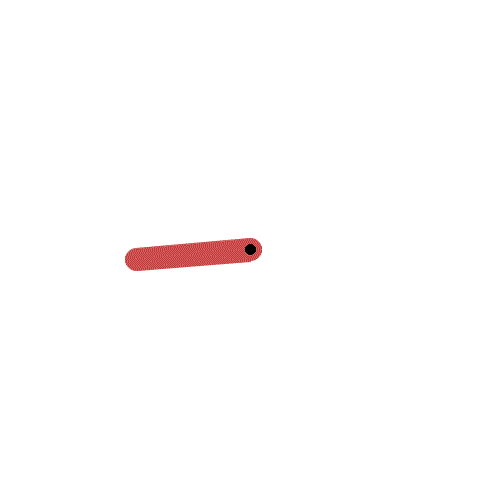

In [ ]:
import tensorflow_docs.vis.embed as embed
from google.colab import files

embed.embed_file('pendulum-v0-240.gif')
# files.download("target_actor_ddpg.h5")
# files.download("target_critic_dppg.h5")0

# Dependencies for Gym Box2D

In [ ]:
# from colabgymrender.recorder import Recorder

def biped_sim():
  # continuous action env
  env = gym.make('BipedalWalker-v3', render_mode='rgb_array', hardcore=True)
  # env = Recorder(env, './video')

  agent = Agent(input_dims=env.observation_space.shape, env=env, \
                n_actions=env.action_space.shape[0])
  n_games = 250

  fig_dir = 'history.png'

  best_score = env.reward_range[0]
  score_history = []
  load_checkpt = False

  if load_checkpt:
    n_steps = 0
    while n_steps <= agent.batch_size:
      s = env.reset()
      a = env.action_space.sample()
      s_, r, done, info = env.step(a)
      agent.remember(s, a, r, s_, done)

      n_steps += 1

    agent.train_step()
    agent.load_models()

    evaluate = True
  else:
    evaluate = False

  for i in range(n_games):
    s = env.reset()
    done = False
    score = 0

    screen = env.render()[0]
    images = [Image.fromarray(screen)]
    render = (i % 50 == 0)

    while not done:
      a = agent.choose_action(s)
      s_, r, done, info = env.step(a)
      score += r
      agent.remember(s, a, r, s_, done)
      if not load_checkpt:
        agent.train_step()
      s = s_

      if render:
        screen = env.render()[0]
        images.append(Image.fromarray(screen))

    if render:
      image_file = 'bipedal-' + str(i) + '.gif'
      images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

    score_history.append(score)
    score_avg = np.mean(score_history[-100:])

    if score_avg > best_score:
      best_score = score_avg
      if not load_checkpt:
        # make tmp/ddpg dir
        agent.save_models()

    # 2 floating point precision
    print('episode ', i, 'score %.2f' % score, 'score_avg %.2f' % score_avg)

  if not load_checkpt:
    x = [i for i in range(n_games)]
    plot_learning_curve(x, score_history, fig_dir)

biped_sim()

  and should_run_async(code)

  deprecation(

  deprecation(



Box(-1.0, 1.0, (4,), float32)



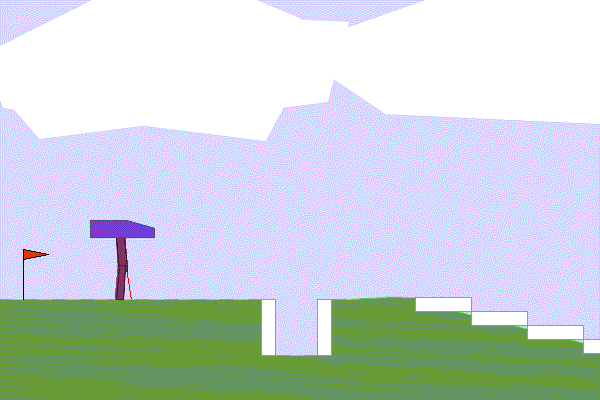

In [ ]:
import tensorflow_docs.vis.embed as embed
from google.colab import files

embed.embed_file('bipedal-50.gif')

# Twin Delayed Deep Deterministic Policy Gradients (TD3)

In [ ]:
'''
Same as previous code blocks with minor modifications
'''

class ReplayBuffer:
  def __init__(self, max_size, input_shape, n_actions):
    self.mem_size = int(max_size)
    self.mem_cntr = 0

    self.state_mem = np.zeros((self.mem_size, *input_shape))
    self.action_mem = np.zeros((self.mem_size, n_actions))
    self.reward_mem = np.zeros(self.mem_size)
    self.new_state_mem = np.zeros((self.mem_size, *input_shape))
    self.terminal_mem = np.zeros(self.mem_size, dtype=np.bool)

  def store_transition(self, s, a, r, s_, done):
    i = self.mem_cntr % self.mem_size

    self.state_mem[i] = s
    self.action_mem[i] = a
    self.reward_mem[i] = r
    self.new_state_mem[i] = s_
    self.terminal_mem[i] = done

    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_size, self.mem_cntr)
    idx = np.random.choice(max_mem, batch_size)

    s = tf.convert_to_tensor(self.state_mem[idx], tf.float32)
    a = tf.convert_to_tensor(self.action_mem[idx], tf.float32)
    r = tf.convert_to_tensor(self.reward_mem[idx], tf.float32)
    s_ = tf.convert_to_tensor(self.new_state_mem[idx], tf.float32)
    done = self.terminal_mem[idx]

    return s, a, r, s_, done


class Actor(tf.keras.Model):
  def __init__(self, fc1_dims, fc2_dims, n_actions, \
               name='actor', chkpt_dir='tmp/td3'):
    super(Actor, self).__init__()

    self.model_name = name
    self.chkpt_dir = os.path.join(chkpt_dir, name + '_td3')

    self.fc1 = Dense(fc1_dims, activation='relu')
    self.fc2 = Dense(fc2_dims, activation='relu')
    self.mu = Dense(n_actions, activation='tanh')

  def call(self, s):
    x = self.fc1(s)
    x = self.fc2(x)
    return self.mu(x)


class Critic(tf.keras.Model):
  def __init__(self, fc1_dims, fc2_dims, \
               name='critic', chkpt_dir='tmp/td3'):
    super(Critic, self).__init__()

    self.model_name = name
    self.chkpt_dir = os.path.join(chkpt_dir, name + '_td3')

    self.fc1 = Dense(fc1_dims, activation='relu')
    self.fc2 = Dense(fc2_dims, activation='relu')
    self.q = Dense(1)

  def call(self, s, a):
    x = self.fc1(tf.concat([s, a], axis=1))
    x = self.fc2(x)
    return self.q(x)

In [ ]:
class Agent:
  def __init__(self, env, fc1_dims, fc2_dims, tau, gamma=0.99, \
               update_actor_interval=2, warmup=1000, max_size=1e6, \
               alpha=0.001, beta=0.001, noise=0.1, batch_size=100):
    self.gamma = gamma
    self.tau = tau
    self.alpha = alpha
    self.beta = beta
    self.warmup = warmup
    self.batch_size = batch_size
    self.noise = noise
    self.learn_step_cntr = 0
    self.time_step = 0
    self.n_actions = env.action_space.shape[0]
    self.update_actor_interval = update_actor_interval

    self.max_act = env.action_space.high[0]
    self.min_act = env.action_space.low[0]

    # instantiate class objects
    self.memory = ReplayBuffer(max_size, env.observation_space.shape, self.n_actions)

    self.actor = Actor(fc1_dims, fc2_dims, self.n_actions)
    self.critic_1 = Critic(fc1_dims, fc2_dims, name='critic_1')
    self.critic_2 = Critic(fc1_dims, fc2_dims, name='critic_2')
    self.target_actor = Actor(fc1_dims, fc2_dims, self.n_actions, name='target_actor')
    self.target_critic_1 = Critic(fc1_dims, fc2_dims, name='target_critic_1')
    self.target_critic_2 = Critic(fc1_dims, fc2_dims, name='target_critic_2')

    self.models = {self.actor : self.target_actor,
                   self.critic_1 : self.target_critic_1,
                   self.critic_2 : self.target_critic_2
                   }

    for i, online in enumerate(self.models):
      if i == 0:
        online.compile(optimizer=Adam(learning_rate=alpha), \
                       loss='mean')
        self.models[online].compile(optimizer=Adam(learning_rate=alpha), \
                       loss='mean')

      else:
        online.compile(optimizer=Adam(learning_rate=beta), \
                                    loss='mean_squared_error')
        self.models[online].compile(optimizer=Adam(learning_rate=beta), \
                                    loss='mean_squared_error')

    self.update_network_parameters(tau=1)

  def load_models(self):
    tf.print('.... load models ....')

    for online in self.models:
      target = self.models[online]
      online.load_weights(online.chkpt_dir)
      target.load_weights(target.chkpt_dir)

  def save_models(self):
    tf.print('.... saving models ....')

    for online in self.models:
      target = self.models[online]
      online.save_weights(online.chkpt_dir)
      target.save_weights(target.chkpt_dir)

  def update_network_parameters(self, tau=None):
    if tau is None:
      tau = self.tau

    for online in self.models:
      weights = []
      target = self.models[online]
      for i, w in enumerate(online.weights):
        weights.append(tau * w + (1 - tau) * target.weights[i])
      target.set_weights(weights)

  def choose_action(self, s):
    if self.time_step < self.warmup:
      mu = tf.random.normal(shape=[self.n_actions], stddev=self.noise)
    else:
      s = tf.convert_to_tensor([s], dtype=tf.float32)
      mu = self.actor(s)[0]

    mu += tf.random.normal(shape=[self.n_actions],stddev=self.noise)

    mu = tf.clip_by_value(mu, self.min_act, self.max_act)

    self.time_step += 1

    return mu

  def remember(self, s, a, r, s_, done):
    self.memory.store_transition(s, a, r, s_, done)

  @tf.function
  def update_critics(self, s, a, r, s_, terminal_calc):
    with tf.GradientTape(persistent=True) as tape:
      target_actions = self.target_actor(s_, training=True)
      target_actions += tf.clip_by_value(
          tf.random.normal(shape=[self.n_actions], stddev=0.2), -0.5, 0.5)

      target_actions = tf.clip_by_value(target_actions, self.min_act, self.max_act)

      q1_ = tf.squeeze(
          self.target_critic_1(s=s_, a=target_actions, training=True), 1)
      q2_ = tf.squeeze(
          self.target_critic_2(s=s_, a=target_actions, training=True), 1)

      q1 = tf.squeeze(self.critic_1(s=s, a=a, training=True), 1)
      q2 = tf.squeeze(self.critic_2(s=s, a=a, training=True), 1)

      q_ = tf.math.minimum(q1_, q2_)

      target = r + self.gamma * q_ * terminal_calc

      critic_1_loss = tf.math.reduce_mean(tf.math.square(target - q1))
      critic_2_loss = tf.math.reduce_mean(tf.math.square(target - q2))

    critic_1_grads = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
    critic_2_grads = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)

    self.critic_1.optimizer.apply_gradients(
        zip(critic_1_grads, self.critic_1.trainable_variables)
    )
    self.critic_2.optimizer.apply_gradients(
        zip(critic_2_grads, self.critic_2.trainable_variables)
    )

  @tf.function
  def update_actor(self, s):
    with tf.GradientTape() as tape:
      actions = self.actor(s, training=True)
      actor_loss = -tf.math.reduce_mean(
          self.critic_1(s=s, a=actions, training=True))

    actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor.optimizer.apply_gradients(
        zip(actor_grads, self.actor.trainable_variables)
    )

  # def update_models(self, s, a, r, s_, terminal_calc):
  #   self.update_critics(s, a, r, s_, terminal_calc)

  #   self.learn_step_cntr += 1

  #   if self.learn_step_cntr % self.update_actor_interval != 0:
  #     return

  #   self.update_actor(s)
  #   self.update_network_parameters()

  # def learn(self):
  #   if self.memory.mem_cntr < self.batch_size:
  #     return

  #   s, a, r, s_, done = self.memory.sample_buffer(self.batch_size)
  #   terminal_calc = tf.cast(1 - done, tf.float32)

  #   self.update_models(s, a, r, s_, terminal_calc)

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return

    s, a, r, s_, done = self.memory.sample_buffer(self.batch_size)
    terminal_calc = tf.cast(1 - done, tf.float32)

    self.update_critics(s, a, r, s_, terminal_calc)

    # with tf.GradientTape(persistent=True) as tape:
    #   target_actions = self.target_actor(s_, training=True)
    #   target_actions += tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)

    #   target_actions = tf.clip_by_value(target_actions, self.min_act, self.max_act)

    #   q1_ = tf.squeeze(
    #       self.target_critic_1(s=s_, a=target_actions, training=True), 1)
    #   q2_ = tf.squeeze(
    #       self.target_critic_2(s=s_, a=target_actions, training=True), 1)

    #   q1 = tf.squeeze(self.critic_1(s=s, a=a, training=True), 1)
    #   q2 = tf.squeeze(self.critic_2(s=s, a=a, training=True), 1)

    #   q_ = tf.math.minimum(q1_, q2_)

    #   target = r + self.gamma * q_ * terminal_calc

    #   critic_1_loss = tf.keras.losses.MSE(target, q1)
    #   critic_2_loss = tf.keras.losses.MSE(target, q2)

    # critic_1_grads = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
    # critic_2_grads = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)

    # self.critic_1.optimizer.apply_gradients(
    #     zip(critic_1_grads, self.critic_1.trainable_variables)
    # )
    # self.critic_2.optimizer.apply_gradients(
    #     zip(critic_2_grads, self.critic_2.trainable_variables)
    # )

    if self.learn_step_cntr % self.update_actor_interval != 0:
      return

    self.update_actor(s)
    # with tf.GradientTape() as tape:
    #   actions = self.actor(s, training=True)
    #   actor_loss = -tf.math.reduce_mean(
    #       self.critic_1(s=s, a=actions, training=True))

    # actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
    # self.actor.optimizer.apply_gradients(
    #     zip(actor_grads, self.actor.trainable_variables)
    # )

    self.update_network_parameters()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def td3_sim():
  env = gym.make('BipedalWalker-v3', render_mode='rgb_array')

  agent = Agent(env=env, fc1_dims=400, fc2_dims=300, tau=0.005)

  n_games = 1000

  best_score = env.reward_range[0]
  score_history = []

  filename = 'learning_curve_' + str(n_games) + '.png'

  load_checkpt = False
  if load_checkpt:
    n_steps = 0
    while n_steps <= agent.batch_size:
      s = env.reset()
      a = env.action_space.sample()
      s_, r, done, info = env.step(a)
      agent.remember(s, a, r, s_, done)
      n_steps += 1
    agent.learn()
    agent.load_models()

  for i in range(n_games):
    s = env.reset()
    done = False
    score = 0

    screen = env.render()[0]
    render = (i % 100 == 0)
    images = [Image.fromarray(screen)]

    while not done:
      a = agent.choose_action(s)
      s_, r, done, info = env.step(a)
      agent.remember(s, a, r, s_, done)
      agent.learn()
      score += r
      s_ = s

      if render:
        screen = env.render()[0]
        images.append(Image.fromarray(screen))

    if render:
      images[0].save('bipedal-' + str(i) + '.gif', save_all=True, \
                     append_images=images[1:], loop=0, duration=1)

    score_history.append(score)
    score_avg = np.mean(score_history[-100:])

    if score_avg > best_score:
      best_score = score_avg
      agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'score avg %.1f' % score_avg)

  x = [i for i in range(n_games)]
  plot_learning_curve(x, score_history, filename)

td3_sim()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-3-4391d09cbf90>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

.... saving models ....
episode  0 score -120.3 score avg -120.3
.... saving models ....
episode  1 score -112.6 score avg -116.5
.... saving models ....
episode  2 score -100.3 score avg -111.1
.... saving models ....
episode  3 score -94.6 score avg -107.0
.... saving models ....
episode  4 score -103.9 score avg -106.3
.... saving models ....
episode  5 score -103.4 score avg -105.9
episode  6 score -111.8 score avg -106.7
episode  7 score -130.5 score avg -109.7
episode  8 score -126.0 score avg -111.5
episode  9 score -106.6 score avg -111.0
episode  10 score -129.6 score avg -112.7
episode  11 score -156.1 score avg -116.3
episode  12 score -152.9 score avg -119.1
episode  13 score -154.6 score avg -121.7
episode  14 score -106.1 score avg -120.6
episode  15 score -156.4 score avg -122.9
episode  16 score -157.8 score avg -124.9
episode  17 score -158.8 score avg -126.8
episode  18 score -162.9 score avg -128.7
episode  19 score -160.7 score avg -130.3
episode  20 score -106.3 sc

In [ ]:
import tensorflow_docs.vis.embed as embed
from google.colab import files

embed.embed_file('learning_curve_1000.png')

In [ ]:
embed.embed_file('bipedal-900.gif')

In [ ]:
files.download('tmp/td3/actor_td3.data-00000-of-00001')
files.download('tmp/td3/actor_td3.index')

files.download('tmp/td3/critic_1_td3.data-00000-of-00001')
files.download('tmp/td3/critic_1_td3.index')

files.download('tmp/td3/critic_2_td3.data-00000-of-00001')
files.download('tmp/td3/critic_2_td3.index')

files.download('tmp/td3/target_actor_td3.data-00000-of-00001')
files.download('tmp/td3/target_actor_td3.index')

files.download('tmp/td3/target_critic_1_td3.data-00000-of-00001')
files.download('tmp/td3/target_critic_1_td3.index')

files.download('tmp/td3/target_critic_2_td3.data-00000-of-00001')
files.download('tmp/td3/target_critic_2_td3.index')

In [ ]:
!zip -r /content/file.zip /content/tmp/td3
files.download("/content/file.zip")